<a href="https://colab.research.google.com/github/warlords94/personal-coding/blob/main/Enhanced_Deep_Residual_Networks_for_single_image_super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
div2k_data = tfds.image.Div2k(config = 'bicubic_x4')

div2k_data.download_and_prepare()

train = div2k_data.as_dataset(split = 'train' , as_supervised = True)
train_cache = train.cache()

val = div2k_data.as_dataset(split = 'validation' , as_supervised = True)
val_cache =val.cache()

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteAYHVB4/div2k-train.tfrecord


  0%|          | 0/800 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteAYHVB4/div2k-validation.tfrecord


  0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


In [ ]:
def flip_left_right(lowres_images,highres_images):
  rn = tf.random.uniform(shape =(), maxval = 1)

  return tf.cond(
      rn<0.5,

      lambda: (lowres_images,highres_images),
      lambda: (
          tf.image.flip_left_right(lowres_images),
          tf.image.flip_left_right(highres_images),
      ),
  )

def random_rotate(lowres_images,highres_images):
  rn = tf.random.uniform(shape =() , maxval =4, dtype=tf.int32)
  return tf.image.rot90(lowres_images,rn) , tf.image.rot90(highres_images , rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
  lowres_crop_size = hr_crop_size // scale

  lowres_img_shape = tf.shape(lowres_img)[:2] 
  lowres_width = tf.random.uniform(shape = () ,maxval = lowres_img_shape[1] - lowres_crop_size+1 , dtype=tf.int32)
  lowres_heigth = tf.random.uniform(shape  =() , maxval = lowres_img_shape[0] - lowres_crop_size+1 ,dtype=tf.int32)
  highres_width = lowres_width * scale
  highres_height = lowres_heigth*scale

  lowres_img_cropped = lowres_img[lowres_heigth : lowres_heigth+lowres_crop_size ,lowres_width : lowres_width + lowres_crop_size ]
  highres_img_cropped = highres_img[highres_height : highres_height + hr_crop_size , highres_width : highres_width + hr_crop_size]


  return lowres_img_cropped, highres_img_cropped

In [ ]:
def dataset_object(dataset_cache, training=True):

    ds = dataset_cache
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=4),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

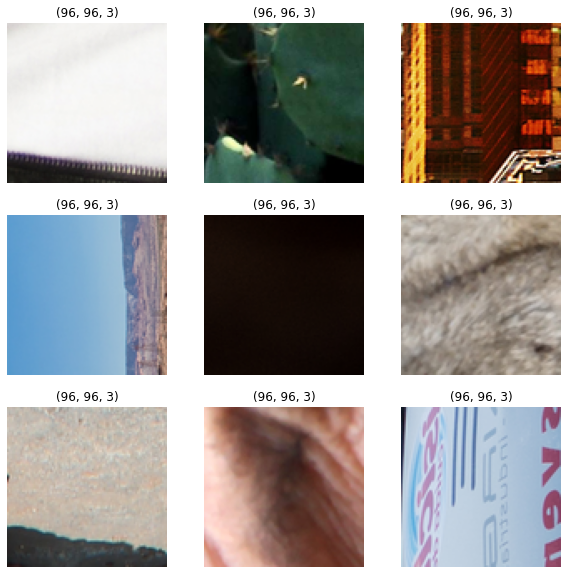

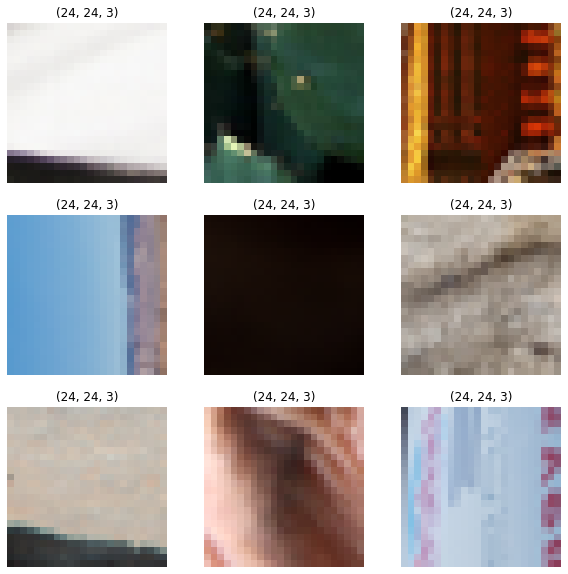

In [ ]:
lowres, highres = next(iter(train_ds))

# Hight Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")


def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

In [ ]:
train_cache

<CacheDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None))>

In [ ]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img


# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)

In [ ]:
# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])
# Training for more epochs will improve results
model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds)

Epoch 1/100
200/200 [==============================] - 628s 3s/step - loss: 27.6447 - PSNR: 19.3365 - val_loss: 14.0207 - val_PSNR: 24.3531
Epoch 2/100
200/200 [==============================] - 525s 3s/step - loss: 12.7978 - PSNR: 25.0273 - val_loss: 11.2904 - val_PSNR: 24.2585
Epoch 3/100
200/200 [==============================] - 536s 3s/step - loss: 11.1003 - PSNR: 26.8388 - val_loss: 10.4336 - val_PSNR: 27.0514
Epoch 4/100
200/200 [==============================] - 531s 3s/step - loss: 9.9063 - PSNR: 28.0678 - val_loss: 10.4573 - val_PSNR: 25.0083
Epoch 5/100
200/200 [==============================] - 533s 3s/step - loss: 9.5324 - PSNR: 28.5680 - val_loss: 9.2206 - val_PSNR: 30.5668
Epoch 6/100
200/200 [==============================] - 538s 3s/step - loss: 9.1460 - PSNR: 28.4070 - val_loss: 8.3885 - val_PSNR: 28.4639
Epoch 7/100
113/200 [===============>..............] - ETA: 3:59 - loss: 8.9338 - PSNR: 27.9813

In [ ]:
def plot_results(lowres, preds):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(24, 14))
    plt.subplot(132), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
    plt.show()


for lowres, highres in val.take(10):
    lowres = tf.image.random_crop(lowres, (150, 150, 3))
    preds = model.predict_step(lowres)
    plot_results(lowres, preds)